# Email Spam Filter Project

## Notebook Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
from os import walk
from os.path import join

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

from sklearn.model_selection import train_test_split
%matplotlib inline

## Constants

In [109]:
EXAMPLE_FILE = "SpamData/01_Processing/practice_email.txt"

SPAM_1_PATH = "SpamData/01_Processing/spam_assassin_corpus/spam_1"
SPAM_2_PATH = "SpamData/01_Processing/spam_assassin_corpus/spam_2"
EASY_NONSPAM_1_PATH = "SpamData/01_Processing/spam_assassin_corpus/easy_ham_1"
EASY_NONSPAM_2_PATH = "SpamData/01_Processing/spam_assassin_corpus/easy_ham_2"

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = "SpamData/01_Processing/email-text-data.json"
WORD_ID_FILE = "SpamData/01_Processing/word-by-id.csv"

TRAINING_DATA_FILE = "SpamData/02_Training/train-data.txt"
TEST_DATA_FILE = "SpamData/02_Training/test-data.txt"

THUMBS_UP_FILE = "SpamData/01_Processing/wordcloud_resources/thumbs-up.png"
THUMBS_DOWN_FILE = "SpamData/01_Processing/wordcloud_resources/thumbs-down.png"
CUSTOM_FONT_FILE = "SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf"

## Reading Files

In [3]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()


print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [4]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)

print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

## Email Body Extraction

In [5]:
def email_body_generator(path):
    
    for root, dirnames, filenames, in walk(path):
        
        for file_name in filenames:            
            filepath = join(root, file_name)
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True
                    
            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body

In [6]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'CATEGORY': classification, 'MESSAGE': email_body})
        row_names.append(file_name)
    
    return pd.DataFrame(rows, index=row_names)

In [7]:
# Spam emails
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = pd.concat([spam_emails,df_from_directory(SPAM_2_PATH, SPAM_CAT)], axis=0)

# Non Spam emails
non_spam_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
non_spam_emails = pd.concat([non_spam_emails,df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT)], axis=0)
spam_emails.shape

(1898, 2)

In [8]:
# Non Spam emails
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = pd.concat([ham_emails,df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT)], axis=0)
ham_emails.shape

(3901, 2)

In [9]:
data = pd.concat([spam_emails, ham_emails])
print('The shape of the dataframe is: ', data.shape)
data.head()

The shape of the dataframe is:  (5799, 2)


,CATEGORY,MESSAGE
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00004.eac8de8d759b7e74154f142194282724,1,##############################################...
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...


In [10]:
data.tail()

,CATEGORY,MESSAGE
01396.61983fbe6ec43f55fd44e30fce24ffa6,0,http://news.bbc.co.uk/1/hi/england/2515127.stm...
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,0,"> >-- be careful when using this one.) Also, t..."
01398.169b51731fe569f42169ae8f948ec676,0,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ..."
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,0,"So then, ""Mark Hammond"" <mhammond@skippinet.co..."
01400.f897f0931e461e7b2e964d28e927c35e,0,"Hi there,\n\n\n\nNow this is probably of no us..."


## Data Cleaning: Checking for Missing Values

In [11]:
# check if any message bodies ar null
data['MESSAGE'].isnull().values.any()

False

In [12]:
# check for empty emails (zero string length)
is_msg_empty = (data.MESSAGE.str.len() == 0).any()
is_msg_empty

True

In [13]:
is_msg_empty.sum()

1

In [14]:
data.MESSAGE.isnull().sum()

0

## Locate & Remove Empty Emails

In [15]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [16]:
data = data.drop(['cmds'], axis=0)

In [17]:
data.shape

(5796, 2)

## Add Documents IDs to Track Emails in Dataset

In [18]:
document_ids = range(0,len(data))
data['DOC_ID'] = document_ids

In [19]:
data['FILE_NAME'] = data.index
data.head()

,CATEGORY,MESSAGE,DOC_ID,FILE_NAME
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",0,00001.7848dde101aa985090474a91ec93fcf0
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,2,00003.2ee33bc6eacdb11f38d052c44819ba6c
00004.eac8de8d759b7e74154f142194282724,1,##############################################...,3,00004.eac8de8d759b7e74154f142194282724
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...,4,00005.57696a39d7d84318ce497886896bf90d


In [20]:
data = data.set_index('DOC_ID')
data.head()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",00001.7848dde101aa985090474a91ec93fcf0
1,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,1,##############################################...,00004.eac8de8d759b7e74154f142194282724
4,1,I thought you might like these:\n\n1) Slim Dow...,00005.57696a39d7d84318ce497886896bf90d


In [21]:
data.tail()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
5791,0,http://news.bbc.co.uk/1/hi/england/2515127.stm...,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,0,"> >-- be careful when using this one.) Also, t...",01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,0,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",01398.169b51731fe569f42169ae8f948ec676
5794,0,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5795,0,"Hi there,\n\n\n\nNow this is probably of no us...",01400.f897f0931e461e7b2e964d28e927c35e


In [22]:
# saving the data as json file
data.to_json(DATA_JSON_FILE)

## Number of Spam Messages Visualised

In [23]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [24]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

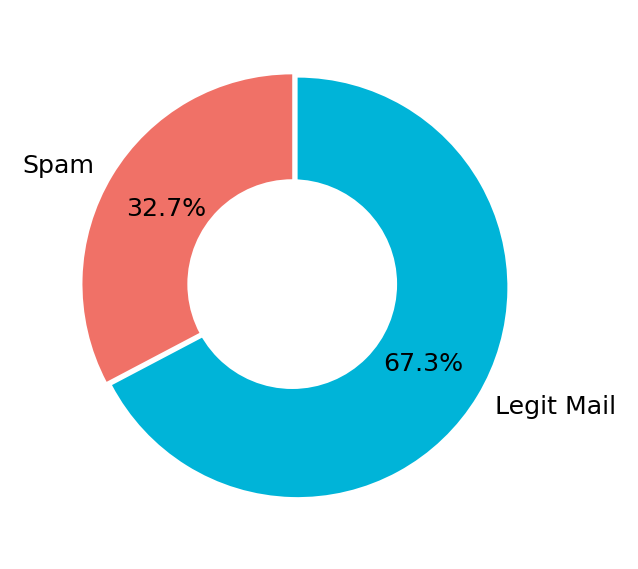

In [25]:
category_names = ['Spam','Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#f07167', '#00b4d8']
offset = [0.0, 0.03]

plt.figure(figsize=(7,3), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize':8}, 
            startangle=90, autopct='%1.1f%%', colors=custom_colours, pctdistance=0.7, explode=offset)

# draw a circle
center_circle = plt.Circle((0 ,0), radius=.5, fc='white')
plt.gca().add_artist(center_circle)
plt.show()

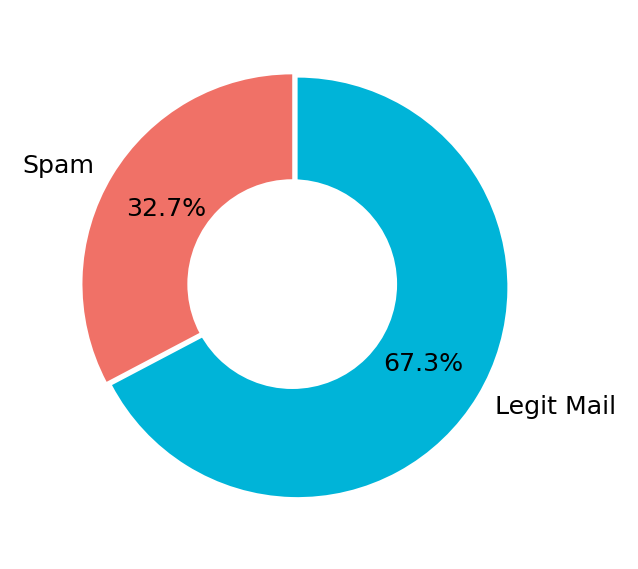

In [26]:
category_names = ['Spam','Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#f07167', '#00b4d8']
offset = [0.0, 0.03]

plt.figure(figsize=(7,3), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize':8}, 
            startangle=90, autopct='%1.1f%%', colors=custom_colours, pctdistance=0.7, explode=offset)

# draw a circle
center_circle = plt.Circle((0 ,0), radius=.5, fc='white')
plt.gca().add_artist(center_circle)
plt.show()

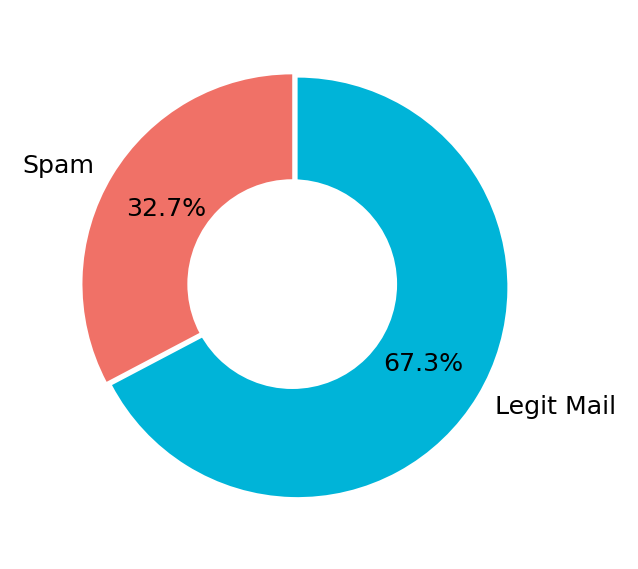

In [27]:
category_names = ['Spam','Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#f07167', '#00b4d8']
offset = [0.0, 0.03]

plt.figure(figsize=(7,3), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize':8}, 
            startangle=90, autopct='%1.1f%%', colors=custom_colours, pctdistance=0.7, explode=offset)

# draw a circle
center_circle = plt.Circle((0 ,0), radius=.5, fc='white')
plt.gca().add_artist(center_circle)
plt.show()

## Natural Language Proccessing

#### Download the NLTK Resources (Tokenizer & Stopwords)

In [28]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [29]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Apply Cleaning and Tokenisation to All Messages

In [30]:
# function for email processing
def clean_msg(message, stemmer=PorterStemmer(),
             stop_words=set(stopwords.words('english'))):
    
    # remove html tags
    soup = BeautifulSoup(message, 'html.parser')
    clean_text = soup.get_text()
    
    # convert message to lower case and split up the words
    words =  word_tokenize(clean_text.lower())
    
    filtered_words = []
    
    for word in words:
        # remove the stop words and punctuation
        
        if word not in stop_words and word.isalpha():           
            filtered_words.append(word)
            
    return filtered_words

In [31]:
%%time
nested_list = data.MESSAGE.apply(clean_msg)
#nested_list

C:\Users\moham\anaconda3\envs\dsEnv\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\moham\anaconda3\envs\dsEnv\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


CPU times: total: 10.1 s
Wall time: 17.5 s


In [32]:
nested_list.tail()

DOC_ID
5791    [http, bizarre, collection, stuffed, animals, ...
5792    [careful, using, one, also, really, cute, thin...
5793    [sm, skip, montanaro, writes, jeremy, put, ano...
5794    [mark, hammond, like, given, zodb, sounding, a...
5795    [hi, probably, use, whatsoever, also, problem,...
Name: MESSAGE, dtype: object

#### Subsetting Series With Index

In [33]:
doc_ids_spam = data[data.CATEGORY==1].index
doc_ids_ham = data[data.CATEGORY==0].index
doc_ids_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

In [34]:
nested_list_ham = nested_list.loc[doc_ids_ham]
nested_list_spam = nested_list.loc[doc_ids_spam]

In [35]:
nested_list_ham.head()

DOC_ID
1896    [date, wed, aug, chris, garrigues, ca, reprodu...
1897    [martin, posted, tassos, papadopoulos, greek, ...
1898    [man, threatens, explosion, moscow, thursday, ...
1899    [klez, virus, wo, die, already, prolific, viru...
1900    [adding, cream, spaghetti, carbonara, effect, ...
Name: MESSAGE, dtype: object

In [36]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()
normal_words.shape # total number of unique words in non-spam messages

(30097,)

In [37]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spam_words = pd.Series(flat_list_spam).value_counts()
spam_words.shape # total number of unique words in spam messages

(18021,)

### Wordclouds (Ham & Spam Messages)

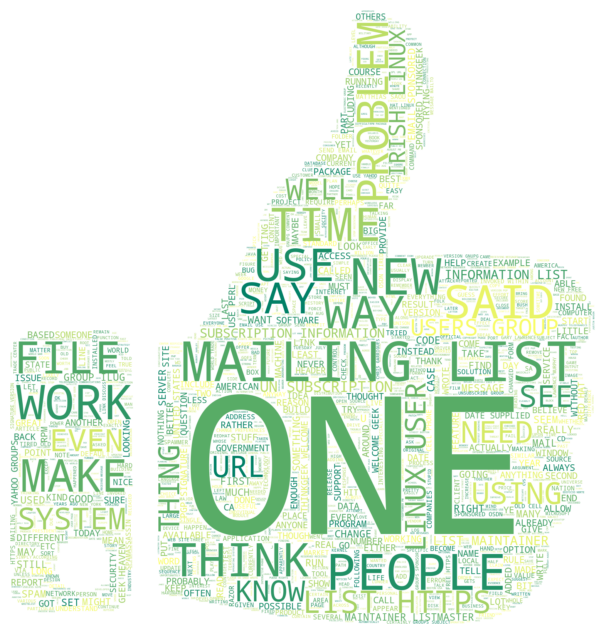

In [38]:
up_icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=up_icon.size, color=(255,255,255))
image_mask.paste(up_icon, box=up_icon)

# generate tje text as a string for the word cloud
ham_str = ' '.join(flat_list_ham)

rgb_array = np.array(image_mask) # converts the image object to an array
word_cloud = WordCloud(mask=rgb_array, background_color='white',max_font_size=500,
                      max_words=1500, colormap='summer')
word_cloud.generate(ham_str.upper())

plt.figure(figsize=(16,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

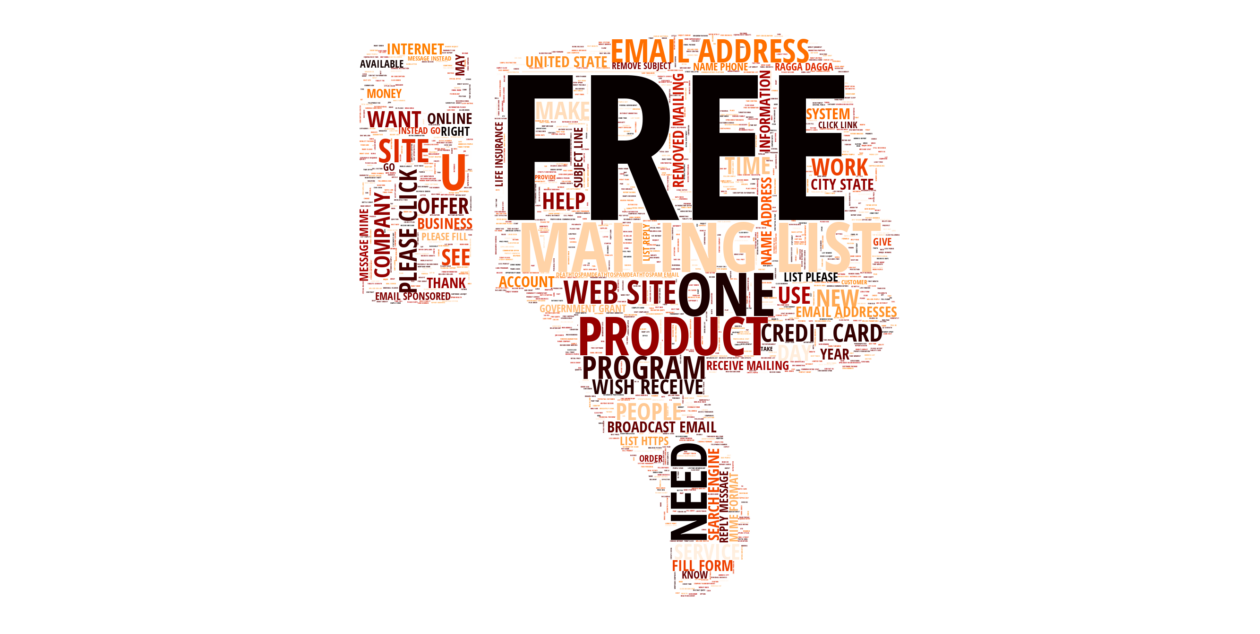

In [39]:
down_icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=down_icon.size, color=(255,255,255))
image_mask.paste(down_icon, box=down_icon)

# generate tje text as a string for the word cloud
spam_str = ' '.join(flat_list_spam)

rgb_array = np.array(image_mask) # converts the image object to an array
word_cloud = WordCloud(mask=rgb_array, background_color='white', max_font_size=500,
                      max_words=1500, colormap='gist_heat', font_path=CUSTOM_FONT_FILE
                      )
word_cloud.generate(spam_str.upper())

plt.figure(figsize=(16,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Generate Vocabulary & Dictionray

In [40]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

C:\Users\moham\anaconda3\envs\dsEnv\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\moham\anaconda3\envs\dsEnv\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [41]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print("Number of Uniue Words: ", unique_words.shape[0])
unique_words.head()

Number of Uniue Words:  38283


http     9511
list     4211
email    3995
one      3751
get      3490
dtype: int64

In [42]:
frequent_words = unique_words[0:VOCAB_SIZE]
frequent_words.head(10)

http           9511
list           4211
email          3995
one            3751
get            3490
free           3193
would          2746
people         2642
new            2624
information    2532
dtype: int64

### Vocabulary DataFrame with a WORD_ID

In [43]:
word_ids = list(range(0,VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,list
2,email
3,one
4,get


### Save the Vocabulary as a CSV File

In [44]:
vocab.to_csv(WORD_ID_FILE, index=vocab.index.name, header=vocab.VOCAB_WORD.name)

In [45]:
email_length = []
for item in stemmed_nested_list:
    email_length.append(len(item))

In [46]:
email_length2 = [len(item) for item in stemmed_nested_list]
print(max(email_length2))

7671


In [47]:
np.argmax(email_length2)

5775

In [48]:
print(data.at[np.argmax(email_length2), 'MESSAGE'][:620])

------------------------ Yahoo! Groups Sponsor ---------------------~-->

4 DVDs Free +s&p Join Now

http://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM

---------------------------------------------------------------------~->



A new version of unison is now available for testing.  It incorporates

several small improvements over 2.9.1, but the main change is a fix to

a bug that had potentially serious safety consequences, but only for

the very small number of users that are in the habit of running more

than one instance of Unison at a time, in parallel.  These users are

strongly encouraged to upgrade.


### Generate Features & Sparse Matrix

#### Creating a DataFrame with one Word per Column

In [49]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insurance,spend,life,quote,savings,g,family,financial,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guaranteed,lose,lbs,days,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guaranteed,lose,lbs,days,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offers,free,membership,instant,access,sites,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guaranteed,lose,lbs,days,http,fight,...,None,None,None,None,None,None,None,None,None,None


In [50]:
word_columns_df.shape

(5796, 7671)

### Splitting the Data into a Training and Testing Dataset

In [51]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY,
                                                   test_size=0.3, random_state=42)

In [52]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,yes,indeed,agents,directory,veritas,cd,unix,subdirectory,file,called,...,None,None,None,None,None,None,None,None,None,None
4727,problem,comes,try,install,harddissssk,like,already,mounted,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,original,message,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inline,folks,several,major,internet,outages,morning,across,major,providers,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicle,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [53]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4675,interesting,always,wondered,things,bad,example,goto,languages,support,goto,...,None,None,None,None,None,None,None,None,None,None
4220,url,http,date,final,gdc,europe,review,confernece,sessions,ects,...,None,None,None,None,None,None,None,None,None,None
2484,stephen,williams,mailto,swilliams,weaken,food,transaction,argument,note,neighborhood,...,None,None,None,None,None,None,None,None,None,None
2418,el,mon,sep,bitbitch,wrote,eugen,many,homo,friends,lovers,...,None,None,None,None,None,None,None,None,None,None
5110,music,school,jokes,american,conductor,european,conductor,talking,european,conductor,...,None,None,None,None,None,None,None,None,None,None


In [54]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

#### Create a Sparse Matrix for the Training Data

In [63]:
word_index = pd.Index(vocab.VOCAB_WORD)
word_index

Index(['http', 'list', 'email', 'one', 'get', 'free', 'would', 'people', 'new',
       'information',
       ...
       'native', 'unknown', 'wholesale', 'odd', 'naturally', 'listings',
       'becomes', 'older', 'implement', 'town'],
      dtype='object', name='VOCAB_WORD', length=2500)

In [69]:
word_index.get_loc('native')

2490

In [70]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Retrurns sparse matrix as dataframe.
    
    df: A dataframe with words in the columns with a document id as an index (X_train, or X_test)
    indexed_words: index of words ordered by word_id
    labels: category as a series (y_train, or y_test)
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            word = df.iat[i,j]
            
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id,
                       'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
            
    return pd.DataFrame(dict_list)

In [94]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index,y_train)

CPU times: total: 7min 6s
Wall time: 7min 12s


In [72]:
sparse_train_df.shape

(375640, 4)

In [73]:
sparse_train_df.head()

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4844,1,206
1,0,4844,1,1221
2,0,4844,1,1067
3,0,4844,1,342
4,0,4844,1,248


In [74]:
sparse_train_df.tail()

,LABEL,DOC_ID,OCCURENCE,WORD_ID
375635,1,860,1,382
375636,1,860,1,25
375637,1,860,1,111
375638,1,860,1,1172
375639,1,860,1,388


#### Combine Occurences with the Pandas groupby() Method

In [76]:
train_grouped = sparse_train_df.groupby(['DOC_ID','WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      1       1              1
       2       1              2
       4       1              1
       5       1              3
       8       1              1

In [78]:
train_grouped.shape

(239017, 1)

In [79]:
vocab.at[0, 'VOCAB_WORD']

'http'

In [82]:
train_grouped = train_grouped.reset_index()
train_grouped.tail()

,index,DOC_ID,WORD_ID,LABEL,OCCURENCE
239012,239012,5795,2131,0,2
239013,239013,5795,2138,0,2
239014,239014,5795,2182,0,13
239015,239015,5795,2243,0,1
239016,239016,5795,2455,0,1


In [88]:
vocab.at[2182,'VOCAB_WORD']

'nvidia'

In [89]:
data.MESSAGE[5795]

"Hi there,\n\n\n\nNow this is probably of no use to you whatsoever, but...\n\n\n\nNot a deb-head, but I also have a problem regards NVidia. I've two machines,\n\npretty much the same hardware. \n\nathlon 1700XP's, both have NVidia cards, one Gforce3 Ti and a Gforce2MX,\n\nboth use the same driver module. \n\n\n\nBoth have same kernel version albeit it compiled for their particular\n\nhardware.\n\n\n\nOne works perfectly, the other fails to load. When I check with lsmod, I can\n\nsee the NVdriver is loaded, but not used ;--(\n\nThus when I startx, it bombs out. \n\n\n\nIU still have X with the default nv driver and crappy accelleration -->\n\n650fps with glxgears [should be over 2000fps]\n\nIts not a hardware issue with the cards as I swapped them over and get the\n\nsame symptoms. \n\n\n\nI reckon my mobo is cack, I've tried swapping slots around, reserving\n\nresources etc all to no avail. \n\nShould there be an interrupt for the nv card? I haven't checked the other\n\nbox yet.\n\n\n\

#### Create a Sparse Matrix for the Testing Data

In [111]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4675,interesting,always,wondered,things,bad,example,goto,languages,support,goto,...,None,None,None,None,None,None,None,None,None,None
4220,url,http,date,final,gdc,europe,review,confernece,sessions,ects,...,None,None,None,None,None,None,None,None,None,None
2484,stephen,williams,mailto,swilliams,weaken,food,transaction,argument,note,neighborhood,...,None,None,None,None,None,None,None,None,None,None
2418,el,mon,sep,bitbitch,wrote,eugen,many,homo,friends,lovers,...,None,None,None,None,None,None,None,None,None,None
5110,music,school,jokes,american,conductor,european,conductor,talking,european,conductor,...,None,None,None,None,None,None,None,None,None,None


In [112]:
X_test.shape

(1739, 7671)

In [95]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

CPU times: total: 3min 6s
Wall time: 3min 9s


In [96]:
sparse_test_df.shape

(178390, 4)

In [97]:
sparse_test_df.head()

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4675,1,671
1,0,4675,1,236
2,0,4675,1,165
3,0,4675,1,381
4,0,4675,1,274


In [104]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID','LABEL']).sum()
test_grouped = test_grouped.reset_index()
test_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
109349,5793,1978,0,2
109350,5793,1983,0,1
109351,5793,2123,0,1
109352,5793,2326,0,1
109353,5793,2445,0,3


In [105]:
test_grouped.shape

(109354, 4)

In [106]:
vocab.at[2445,'VOCAB_WORD']

'bound'

In [107]:
data.MESSAGE[5793]

'>>>>> "SM" == Skip Montanaro <skip@pobox.com> writes:\n\n\n\n  Jeremy> Put another way, I\'d be interested to hear why you don\'t\n\n  Jeremy> want to use ZODB.\n\n\n\n  SM> Disclaimer: I\'m not saying I don\'t want to use ZODB.  I\'m\n\n  SM> offering some reasons why it might not be everyone\'s obvious\n\n  SM> choice.\n\n\n\nBut you\'re not saying you do want to use ZODB, so you\'re still part of\n\nthe problem <wink>.\n\n\n\n  SM> For most of us who have *any* experience with ZODB it\'s probably\n\n  SM> all indirect via Zope, so there are probably some inaccurate\n\n  SM> perceptions about it.  These thoughts that have come to my mind\n\n  SM> at one time or another:\n\n\n\n  SM> * How could a database from a company (Zope) whose sole business\n\n  SM>       is not databases be more reliable than a database from\n\n  SM>       organizations whose sole raison d\'etre is databases\n\n  SM>       (Sleepycat, Postgres, MySQL, ...)?\n\n\n\nI don\'t think I could argue that ZODB is mor

### Save Training Dat as .txt File

In [91]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [92]:
train_grouped.columns

Index(['index', 'DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

In [110]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')